In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [3]:
!nvidia-smi

Sun Jan  8 16:54:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Preparations

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/AppliedGPU_hw4/ex_4'
!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/AppliedGPU_hw4/ex_4
lab4_ex4  lab4_ex4.cu


#Compiling

In [5]:
!nvcc -arch=sm_75 -lcublas -lcusparse ./lab4_ex4.cu -o lab4_ex4

# Execution

In [7]:
!./lab4_ex4 64 4

The X dimension of the grid is 64 
The number of time steps to perform is 4 
Timing - Allocating device memory. 		Elasped 197161 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 42 microseconds 
Timing - Initializing memory on the host. 		Elasped 1 microseconds 
Timing - Computing the SMPV. 			Elasped 386 microseconds 
The relative error of the approximation is 4.426983


#Plots & Analysis

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import re

###Question 1

In [52]:
%%capture cap
!for i in {2..25..3}; do ./lab4_ex4 $((2 ** i)) 100; done

In [53]:
f = open("dimX_variations.txt", "w") 
print(cap, file=f)
f.close()

In [54]:
re_dimX = "The X dimension of the grid is (.*)"
re_smpv = "Timing - Computing the SMPV. \t\t\tElasped (.*) microseconds"

dimXs = []
smpv_total_times = []

with open("./dimX_variations.txt") as file:
    for line in file:
        line_str = line.rstrip()
        # searching for dimx sizes
        dimX_re = re.search(re_dimX, line_str)
        if dimX_re:
            dimXs.append(float(dimX_re.group(1)))
        # searching for smpv times
        smpv_re = re.search(re_smpv, line_str)
        if smpv_re:
            smpv_total_times.append(float(smpv_re.group(1)) * 1e-6)

In [55]:
print(dimXs)

[4.0, 32.0, 256.0, 2048.0, 16384.0, 131072.0, 1048576.0, 8388608.0]


In [56]:
nsteps = 100
flops = [nsteps * (3 * dimX - 6) / total_time for dimX, total_time in zip(dimXs, smpv_total_times)]

print(flops)

[892857.142857143, 13953488.372093024, 128282828.28282829, 901321585.9030838, 7061206896.551724, 61439062500.00001, 382691240875.9124, 2613272897196.2617]


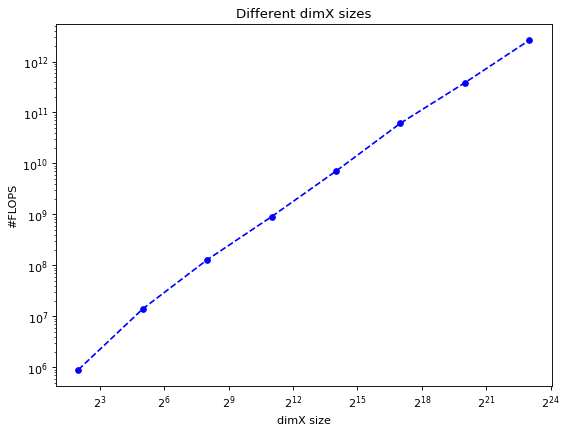

In [85]:
figure(figsize=(8, 6), dpi=80)
plt.plot(dimXs, flops, linestyle='--', marker='o', color='b', markersize=5)
plt.xscale('log', basex=2)
plt.yscale('log', basey=10)
plt.xlabel('dimX size')
plt.ylabel('#FLOPS')
plt.title("Different dimX sizes")
plt.show()

###Question 2

In [68]:
%%capture cap
!for i in {100..10000..200}; do ./lab4_ex4 128 $i; done

In [69]:
f = open("nstep_variations.txt", "w") 
print(cap, file=f)
f.close()

In [ ]:
#re_nsteps = "The number of time steps to perform is (.*)"
#re_errors = "The relative error of the approximation is (.*))"

#nsteps = []
#rel_errors = []

#with open("./nstep_variations.txt") as file:
#    for line in file:
#        line_str = line.rstrip()
#        nstep = re.search(re_nsteps, line_str)
#        if nstep:
#          nsteps.append(float(nstep.group(1)))
#        # search for relative error entries
#        rel_error = re.search(re_errors, line_str)
#        if rel_error:
#            rel_errors.append(float(rel_error.group(1)))


In [70]:
nsteps = []
rel_errors = []

re_float = "[+-]?[0-9]+\.[0-9]+"

with open("./nstep_variations.txt") as file:
    for line in file:
        line_str = line.rstrip()
        # search for relative error entries
        rel_error = re.search(re_float, line_str)
        if rel_error:
            rel_errors.append(float(rel_error.group(0)))
        # searcj for number of timesteps
        split = line_str.rsplit("The number of time steps to perform is ")
        if len(split) != 1:
            nsteps.append(int(split[-1]))

In [71]:
print(nsteps)
print(rel_errors)

[100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900, 2100, 2300, 2500, 2700, 2900, 3100, 3300, 3500, 3700, 3900, 4100, 4300, 4500, 4700, 4900, 5100, 5300, 5500, 5700, 5900, 6100, 6300, 6500, 6700, 6900, 7100, 7300, 7500, 7700, 7900, 8100, 8300, 8500, 8700, 8900, 9100, 9300, 9500, 9700, 9900]
[3.318021, 2.396107, 2.002595, 1.751605, 1.566021, 1.417372, 1.292369, 1.184024, 1.088344, 1.002871, 0.925962, 0.856431, 0.793362, 0.736008, 0.683739, 0.636013, 0.592355, 0.552349, 0.515628, 0.481865, 0.450771, 0.422091, 0.395597, 0.371086, 0.348377, 0.32731, 0.30774, 0.289539, 0.27259, 0.256789, 0.242044, 0.228269, 0.215387, 0.203331, 0.192037, 0.181448, 0.171513, 0.162183, 0.153417, 0.145174, 0.137418, 0.130117, 0.123239, 0.116756, 0.110643, 0.104876, 0.099433, 0.094292, 0.089436, 0.084847]


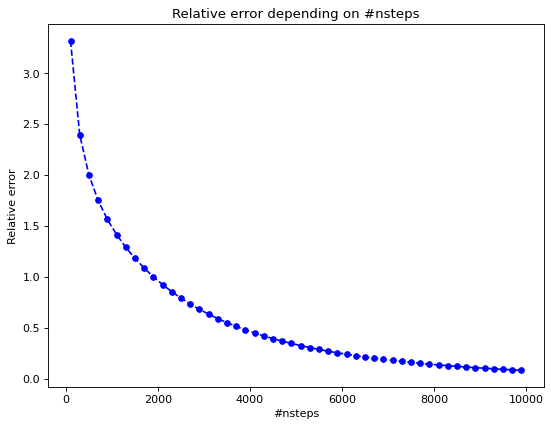

In [83]:
figure(figsize=(8, 6), dpi=80)
plt.plot(nsteps, rel_errors, linestyle='--', marker='o', color='b', markersize=5)
plt.xlabel('#nsteps')
plt.ylabel('Relative error')
plt.title("Relative error depending on #nsteps")
plt.show()

### Question3 

In [77]:
!nvcc -arch=sm_75 -lcublas -lcusparse ./lab4_ex4.cu -o lab4_ex4

In [78]:
!nvprof ./lab4_ex4 128 10000

The X dimension of the grid is 128 
The number of time steps to perform is 10000 
==14810== NVPROF is profiling process 14810, command: ./lab4_ex4 128 10000
Timing - Allocating device memory. 		Elasped 337923 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 71 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 2 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 340 microseconds 
Timing - Computing the SMPV. 			Elasped 179775 microseconds 
The relative error of the approximation is 0.082647
==14810== Profiling application: ./lab4_ex4 128 10000
==14810== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   72.06%  466.66ms     20004  23.328us  16.863us  52.767us  void nrm2_kernel<double, double, double, int=0, int=0, int=128>(cublasNrm2Params<double, double>)
                   13.07%  84.6